<a href="https://colab.research.google.com/github/rakibulhaque9954/sentiment-analysis-imdb/blob/main/IMDB_sentiment_analysis_with_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Acknowledgement

**Based on research by members of Google Brain, Google Research, Univerity of Toronto**<br>
Paper Link: https://arxiv.org/pdf/1706.03762.pdf


# Imports

In [1]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import re
import string
import time
from numpy import random
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from keras.models import Model
from keras.layers import Layer
from keras.layers import (Dense,Flatten,SimpleRNN,InputLayer,Conv1D,Bidirectional,GRU,LSTM,BatchNormalization,Dropout,Input, Embedding,TextVectorization)
from keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from keras.optimizers import Adam
from keras.layers import MultiHeadAttention, LayerNormalization
from google.colab import drive
from google.colab import files
from tensorboard.plugins import projector

# Data Preparation

In [33]:
BATCH_SIZE = 64

In [72]:
train_ds, val_ds, test_ds=tfds.load('imdb_reviews', split=['train', 'test[:50%]', 'test[50%:]'],as_supervised=True)

In [34]:
for review,label in train_ds.take(1):
  print("Review:",review.numpy())
  print("Label:",label.numpy())


Review: b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
Label: 0


## Standardization

In [35]:
def standardization(input_data):
    '''
    Input: raw reviews
    output: standardized reviews
    '''
    lowercase=tf.strings.lower(input_data)
    no_tag=tf.strings.regex_replace(lowercase,"<[^>]+>","")
    output=tf.strings.regex_replace(no_tag,"[%s]"%re.escape(string.punctuation),"")

    return output

In [36]:
standardization(tf.constant("<u>In the movie?, </u>man called Tévèz, went to a friend’s pl**ce and they had a tensed discussion. I don’t love this movie! would you?<br> <br /><br />T"))

<tf.Tensor: shape=(), dtype=string, numpy=b'in the movie man called t\xc3\xa9v\xc3\xa8z went to a friend\xe2\x80\x99s plce and they had a tensed discussion i don\xe2\x80\x99t love this movie would you t'>

## Vectorization

In [37]:
VOCAB_SIZE=10000
SEQUENCE_LENGTH=250
EMBEDDING_DIM=300

In [38]:
vectorize_layer=TextVectorization(
    standardize=standardization,
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH
)

In [39]:
training_data=train_ds.map(lambda x,y:x)### input x and y and outputx
vectorize_layer.adapt(training_data)#### adapt the vectorize_layer to the training data

In [11]:
len(vectorize_layer.get_vocabulary())

10000

In [40]:
def vectorizer(review,label):
    return vectorize_layer(review),label

In [41]:
train_dataset=train_ds.map(vectorizer)
val_dataset=val_ds.map(vectorizer)

In [14]:
vectorize_layer.get_vocabulary()[0:10]

['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it']

In [15]:
for review,label in train_dataset.take(1):
  print("Review:",review)
  print("Label:",label.numpy())


Review: tf.Tensor(
[  10   13   33  411  384   17   89   26    1    8   32 1337 3521   40
  491    1  192   22   84  149   18   10  215  317   26   64  239  212
    8  484   54   64   84  111   95   21 5502   10   91  637  737   10
   17    7   33  393 9554  169 2443  406    2   87 1205  135   65  142
   52    2    1 7408   65  245   64 2832   16    1 2851    1    1 1415
 4969    3   39    1 1567   15 3521   13  156   18    4 1205  881 7874
    8    4   17   12   13 4037    5   98  145 1234   11  236  696   12
   48   22   91   37   10 7285  149   37 1337    1   49  396   11   95
 1148  841  140    9    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0   

## Datasets Prefecthing and Batching

In [42]:
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Modeling

<hr>
<h4>Model Architecture (only Encoder)</h4>
<hr>
<img src='https://miro.medium.com/v2/resize:fit:490/1*THykpgtL058A9EpkstnUJQ.png'>

***Step Wise Explanation:***
- Transformer Encoder Block: In sentiment analysis, we usually leverage the transformer encoder architecture. It excels at capturing contextual information from the input text.
- Contextual Vectors: The encoder processes the input text and produces contextual vectors for each word or subword in the sequence. These vectors contain rich information about the words and their relationships within the context of the sentence.
- Flattening: After obtaining the contextual vectors, you can flatten or concatenate them into a single vector representation. This helps in summarizing the entire input sequence into a fixed-size representation.
- Fully Connected Layer: The flattened vectors are then passed through a fully connected neural network layer. This layer typically consists of multiple neurons or units.
- Sigmoid Activation: To perform binary sentiment classification (positive/negative), a sigmoid activation function is commonly used in the output layer. It squashes the values to the range [0, 1], making it suitable for binary classification.

<h4>Inside Attention Layer</h4>
<img src='https://production-media.paperswithcode.com/methods/35184258-10f5-4cd0-8de3-bd9bc8f88dc3.png'>

Encoder's Role (Intra-Attention in Encoder):
The encoder processes the input sequence and performs intra-attention.
It produces context vectors (contextual representations) for each word in the input sequence.
These context vectors capture information about how each word relates to others within the input sequence.


## Transformers Architecture for Sentiment Analysis
***Similar to BERT***

<img src="https://www.mihaileric.com/static/feedforward_layer_and_normalization-dfdcfbd00009f7f99eca73ae29f2dfb7-4ec3a.png">

### Positional Encoding

In [18]:
def positional_encoding(model_size, SEQUENCE_LENGTH): # d_model
  output = []
  for pos in range(SEQUENCE_LENGTH):
    PE = np.zeros((model_size)) # initilizing with zeros
    for i in range(model_size):
      if i % 2 == 0: # even positions, sin formula is used according to paper
        PE[i] = np.sin(pos/(10000**(i/model_size)))
      else: # odd positions, cos formula is used as mentioned in the paper
        PE[i] = np.cos(pos/(10000**((i-1)/model_size)))
    output.append(tf.expand_dims(PE, axis = 0))

  out = tf.concat(output, axis=0)
  out = tf.expand_dims(out, axis=0)
  return tf.cast(out, dtype=tf.float32)

In [19]:
print(positional_encoding(256, 32).shape)

(1, 32, 256)


### Input Embeddings

In [20]:
class Embeddings(Layer):
  def __init__(self, sequence_length, vocab_size, embedding_dim):
    super(Embeddings, self).__init__()
    self.token_embeddings = Embedding(input_dim=vocab_size, output_dim=embedding_dim)
    self.sequence_length = sequence_length
    self.vocab_size = vocab_size
    self.embedding_dim = embedding_dim

  def call(self, inputs):
    embedded_tokens = self.token_embeddings(inputs)
    embedded_positions = positional_encoding(self.embedding_dim, self.sequence_length) # PE adding here
    return embedded_tokens + embedded_positions # final output for inputs

  def compute_mask(self, inputs, mask=None):
    return tf.math.not_equal(inputs, 0) # masking function for checking if there are pad tokens(0)



### Custom Attention Layers



**Self Attention Layer**
<hr>

In [21]:
class CustomSelfAttention(Layer):
  def __init__(self, model_size):
    super(CustomSelfAttention, self).__init__()
    self.model_size = model_size

  def call(self, query, key, value, masking):
    #### Compute Scores ####
    score = tf.matmul(query, key, transpose_b=True)

    #### Scaling ####
    score = score / tf.math.sqrt(tf.cast(self.model_size, dtype=tf.float32))

    #### Masking ####
    masking = tf.cast(masking, dtype=tf.float32)
    score -= (1.0 - masking) * 1e10

    #### Attention Weights ####
    attention_weights = tf.nn.softmax(score, axis=-1) * masking

    #### Weighted Sum ####
    head_output = tf.matmul(attention_weights, value)

    #### Output ####
    return head_output



**Multi-Head-Attention Layer**
<hr>

In [ ]:
class CustomMultiHeadAttention(Layer):
  def __init__(self, num_heads, key_dim):
    super(CustomMultiHeadAttention, self).__init__()

    self.num_heads = num_heads
    self.dense_q = [Dense(key_dim//num_heads) for _ in range(num_heads)]
    self.dense_k = [Dense(key_dim//num_heads) for _ in range(num_heads)]
    self.dense_v = [Dense(key_dim//num_heads) for _ in range(num_heads)]
    self.dense_o = Dense(key_dim)
    self.attention = CustomSelfAttention(key_dim)

  def call(self, query, key, value, attention_mask):
    heads = []

    for i in range(self.num_heads): # for each head
      print(f'head-{i}', self.dense_q[i](query).shape)
      head = self.self_attention(self.dense_q[i](query), self.dense_k[i](key),
                                 self.dense_v[i](value), attention_mask)

      heads.append(head)
    heads = tf.concat(heads, axis=2) # concatenating all heads
    heads = self.dense_o(heads) # passing all heads through a linear layer for the final output
    return heads


### Encoder Layer

In [22]:
class TransformerEncoder(Layer):
  def __init__(self, embedding_dims, dense_dims, num_heads):
    super(TransformerEncoder, self).__init__()
    self.embedding_dims = embedding_dims
    self.dense_dims = dense_dims
    self.num_heads = num_heads
    self.attention = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dims)

    self.dense_proj = tf.keras.Sequential([
        Dense(self.dense_dims, activation="relu"),
        Dense(self.embedding_dims),
    ])
    self.layernorm_1 = LayerNormalization()
    self.layernorm_2 = LayerNormalization()
    self.supports_masking = True

  def call(self, inputs, mask=None):
    # print(mask)
    if mask is not None:
      mask = tf.cast(mask[:, tf.newaxis, :], dtype='int32')
      # print(mask)
      T = tf.shape(mask)[2]
      padding_mask = tf.repeat(mask, T, axis=1)
      # print(padding_mask)

    attention_output = self.attention(query=inputs, value=inputs, key=inputs, attention_mask=padding_mask)

    proj_input = self.layernorm_1(inputs + attention_output)
    proj_output = self.dense_proj(proj_input)
    return self.layernorm_2(proj_input + proj_output)

In [ ]:
##### Test for Encoder #####
# test_input = tf.random.uniform((1, 10, 256))
# test_mask = tf.cast(tf.random.uniform((1, 10)) > 0.5, tf.int32)
# encoder = TransformerEncoder(embedding_dims=256, dense_dims=512, num_heads=8)(output_embed)
# print(encoder.shape)


### Full Transfomers Model for sentiment classification

In [27]:
EMBEDDING_DIMS = 128
NUM_HEADS = 8
NUM_LAYERS = 1
NUM_EPOCHS = 10
LATENT_DIMS = 1024

In [28]:
encoder_inputs = Input(shape=(None,), dtype='int64', name='input')
embeddings = Embeddings(SEQUENCE_LENGTH, VOCAB_SIZE, EMBEDDING_DIMS)
x = embeddings(encoder_inputs)



for _ in range(NUM_LAYERS): # there can be N number of layers as mentioned by paper
  x = TransformerEncoder(EMBEDDING_DIMS, LATENT_DIMS, NUM_HEADS)(x)

x = Flatten()(x) # flattening all the contextual vectors

output = Dense(1, activation='sigmoid')(x) # classification

sentiment_transformer = tf.keras.Model(encoder_inputs, output, name='sentiment_transformer')

sentiment_transformer.summary()

Model: "sentiment_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embeddings_2 (Embeddings)   (None, 250, 128)          1280000   
                                                                 
 transformer_encoder_1 (Tra  (None, 250, 128)          791296    
 nsformerEncoder)                                                
                                                                 
 flatten_1 (Flatten)         (None, 32000)             0         
                                                                 
 dense_5 (Dense)             (None, 1)                 32001     
                                                                 
Total params: 2103297 (8.02 MB)
Trainable params: 2103297 (8.02 MB)
Non-trainable params: 0 (0.00 Byte)
_______

# Training

## BLEU Metric

In [43]:
class BLEU(tf.keras.metrics.Metric):
    def __init__(self,name='bleu_score'):
        super(BLEU,self).__init__()
        self.bleu_score=0

    def update_state(self,y_true,y_pred,sample_weight=None):
      y_pred=tf.argmax(y_pred,-1)
      self.bleu_score=0
      for i,j in zip(y_pred,y_true):
        tf.autograph.experimental.set_loop_options()

        total_words=tf.math.count_nonzero(i)
        total_matches=0
        for word in i:
          if word==0:
            break
          for q in range(len(j)):
            if j[q]==0:
              break
            if word==j[q]:
              total_matches+=1
              j=tf.boolean_mask(j,[False if y==q else True for y in range(len(j))])
              break

        self.bleu_score+=total_matches/total_words

    def result(self):
        return self.bleu_score/BATCH_SIZE

## Compilation and Fitting

In [47]:
sentiment_transformer.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy'],
)



In [48]:
history = sentiment_transformer.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset)

Epoch 1/10
391/391 [==============================] - 56s 122ms/step - loss: 0.7194 - accuracy: 0.5190 - val_loss: 0.7033 - val_accuracy: 0.4967
Epoch 2/10
391/391 [==============================] - 32s 82ms/step - loss: 0.7030 - accuracy: 0.5260 - val_loss: 0.6960 - val_accuracy: 0.4978
Epoch 3/10
391/391 [==============================] - 33s 84ms/step - loss: 0.6915 - accuracy: 0.5461 - val_loss: 0.6939 - val_accuracy: 0.5010
Epoch 4/10
391/391 [==============================] - 33s 85ms/step - loss: 0.6739 - accuracy: 0.5764 - val_loss: 0.7104 - val_accuracy: 0.4974
Epoch 5/10
391/391 [==============================] - 33s 85ms/step - loss: 0.5391 - accuracy: 0.7245 - val_loss: 0.4843 - val_accuracy: 0.7629
Epoch 6/10
391/391 [==============================] - 33s 85ms/step - loss: 0.3405 - accuracy: 0.8530 - val_loss: 0.5077 - val_accuracy: 0.7694
Epoch 7/10
391/391 [==============================] - 33s 85ms/step - loss: 0.2842 - accuracy: 0.8824 - val_loss: 0.3738 - val_accuracy

In [ ]:
sentiment_transformer.save('transformer.hdf5')

# Testing and Evaluation

## Model loss and accuracy plots

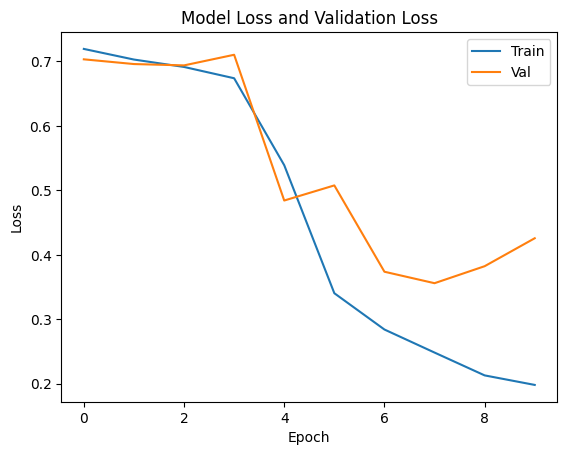

In [49]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'])
plt.show()


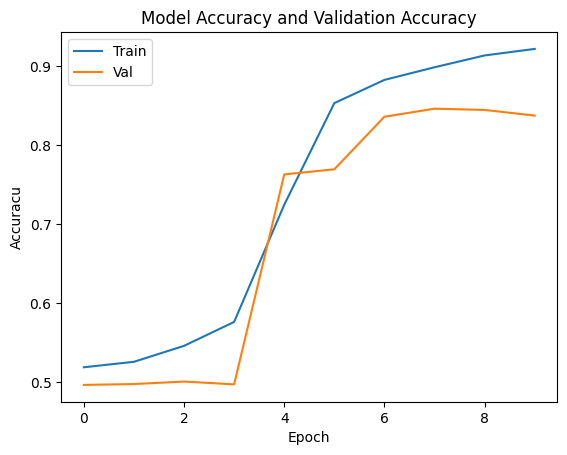

In [50]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracu')
plt.legend(['Train', 'Val'])
plt.show()


##Evaluation

In [73]:
test_dataset=test_ds.map(vectorizer) # vectorizing
test_dataset=test_dataset.batch(BATCH_SIZE) # batching
sentiment_transformer.evaluate(test_dataset)

196/196 [==============================] - 6s 27ms/step - loss: 0.4266 - accuracy: 0.8346


[0.4265553951263428, 0.8346400260925293]

# Testing

In [65]:
test_data = tf.data.Dataset.from_tensor_slices([["this movie looks very interesting, i love the fact that the actors do a great job in showing how people lived in the 18th century, which wasn't very good at all. But atleast this movie recreates this scenes! "],
                                              ["very good start, but movie started becoming uninteresting at some point though initially i thought it would have been much more fun. There was too much background noise, so in all i didn't like this movie "],])


In [66]:
def vectorizer_test(review):
  return vectorize_layer(review)

test_dataset = test_data.map(vectorizer_test)




In [67]:
for review in test_dataset:
  if sentiment_transformer.predict(review) > 0.6:
    print("Positive", sentiment_transformer.predict(review))
  else:
    print("Negative", sentiment_transformer.predict(review))



1/1 [==============================] - 0s 19ms/step
Positive [[0.989176]]
1/1 [==============================] - 0s 18ms/step
Negative [[0.12883693]]


# Evaluation Metrics

In [ ]:
y_true = []
y_pred = []

for X_batch, y_batch in test_dataset:
    y_true.extend(y_batch)
    y_pred_batch = sentiment_transformer.predict(X_batch)
    y_pred.extend(np.round(y_pred_batch).flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

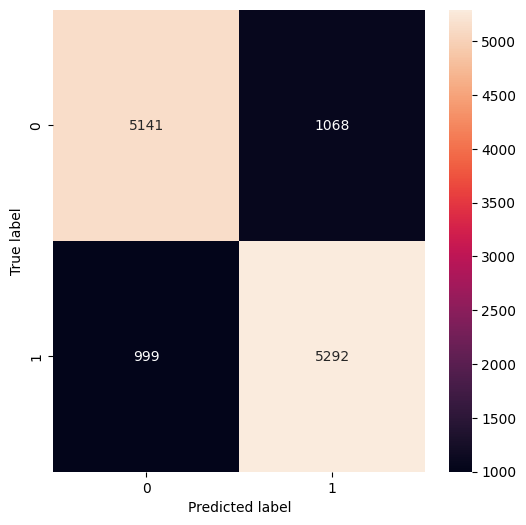

In [77]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [78]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.83      0.83      6209
           1       0.83      0.84      0.84      6291

    accuracy                           0.83     12500
   macro avg       0.83      0.83      0.83     12500
weighted avg       0.83      0.83      0.83     12500



***More training and Hyperparams tuning can definitely increase the accuracy and can lead to a better and more accurate model.***